`Итоговое задание`\
В рамках этого итогового задания мы будем` прогнозировать сердечную недостаточность`.

С описанием датасета можно познакомиться здесь(https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction), но сам датасет(https://disk.yandex.ru/d/gCVRjDJiR1tpSg) для обучения нужно будет скачать тут, датасет для тестирования — тут(https://disk.yandex.ru/d/9aX3UpcRlYAJIw). 

Плана по выполнению задания не будет. 
Но есть несколько требований: 

- оберните весь конвейер преобразований в Pipeline

- подберите оптимальный вариант прогнозной модели с помощью GridSearchCV

- примените обученный на тренировочных данных конвейер к тестовым данным, никак не предобрабатывая их, а лишь загрузив из файла и отделив целевой признак от остальных

- получите на тестовой части качество не ниже `0.87` по метрике `ROCAUC`

Пояснение: если пропуски в новых данных и будут, то только в тех колонках, где они есть в тренировочной части.

In [20]:
import pandas as pd
import dill as pickle
import requests
import json
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn import tree
from sklearn.tree import plot_tree

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import phik as phik_matrix

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 50)

In [21]:
# Загружаем данные из файла 'heart_adapt_train.csv' в DataFrame под названием data_train
data_train = pd.read_csv('heart_adapt_train.csv')
# Выводим первые пять строк data_train для проверки
data_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,74.0,M,NAP,138.0,NaN,0,Normal,116,N,0.2,Up,0
1,58.0,M,NAP,132.0,224.0,0,LVH,173,N,3.2,Up,1
2,44.0,M,ATA,150.0,288.0,0,Normal,150,Y,3.0,Flat,1
3,50.0,M,ASY,144.0,349.0,0,LVH,120,Y,1.0,Up,1
4,NaN,M,ASY,145.0,248.0,0,Normal,96,Y,2.0,Flat,1


In [22]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589 entries, 0 to 588
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             533 non-null    float64
 1   Sex             589 non-null    object 
 2   ChestPainType   589 non-null    object 
 3   RestingBP       588 non-null    float64
 4   Cholesterol     462 non-null    float64
 5   FastingBS       589 non-null    int64  
 6   RestingECG      589 non-null    object 
 7   MaxHR           589 non-null    int64  
 8   ExerciseAngina  589 non-null    object 
 9   Oldpeak         589 non-null    float64
 10  ST_Slope        589 non-null    object 
 11  HeartDisease    589 non-null    int64  
dtypes: float64(4), int64(3), object(5)
memory usage: 55.3+ KB


- уже видно, что есть пропуски в данных в колонках:  Age,         RestingBP,            Cholesterol     

- Изучим данные 

`Age`: возраст пациента [years]

`Sex`: пол пациента [`M`: Male, `F`: Female]

`ChestPainType`: боль в груди type [`TA`: Типичная стенокардия, `ATA`: Атипичная стенокардия, `NAP`: Неангинальная боль, `ASY`: Асимптоматический]

`RestingBP`: артериальное давление в покое [mm Hg]

`Cholesterol`: холестерин в сыворотке крови [mm/dl]

`FastingBS`: быстрый сахар крови [`1`: if FastingBS > 120 mg/dl, `0`: otherwise]

`RestingECG`: результаты электрокардиограммы покоя [`Normal`: Normal, `ST`: наличие аномалии волны ST-T (Инверсии Т-волны и/или подъем или депрессия ST > 0.05 mV), `LVH`: наличие вероятной или определенной гипертрофии левого желудочка по критериям Эстеса]

`MaxHR`: максимальная частота сердечных сокращений [`Числовое значение` в диапазоне от 60 до 202]

`ExerciseAngina`: стенокардия, вызванная физической нагрузкой [`Y`: Yes, `N`: No]

`Oldpeak`: oldpeak = ST [`Числовое значение`, измеренное в депрессии]

`ST_Slope`: наклон пикового сегмента ST при физической нагрузке [`Up`: наклонная, `Flat`: flat, Down: наклонная]

`HeartDisease`: выходной класс [`1`: сердечно-сосудистые заболевания, `0`: норма]


In [23]:
data_train.describe(include='all').fillna('-').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,533.0,-,-,-,54.195122,9.532661,28.0,48.0,55.0,61.0,77.0
Sex,589,2,M,477,-,-,-,-,-,-,-
ChestPainType,589,4,ASY,348,-,-,-,-,-,-,-
RestingBP,588.0,-,-,-,133.358844,18.851852,80.0,120.0,130.0,144.0,200.0
Cholesterol,462.0,-,-,-,245.632035,58.599184,85.0,209.0,240.0,279.75,603.0
FastingBS,589.0,-,-,-,0.258065,0.437942,0.0,0.0,0.0,1.0,1.0
RestingECG,589,3,Normal,345,-,-,-,-,-,-,-
MaxHR,589.0,-,-,-,134.893039,24.942596,63.0,117.0,135.0,154.0,195.0
ExerciseAngina,589,2,N,325,-,-,-,-,-,-,-
Oldpeak,589.0,-,-,-,0.937521,1.071318,-2.6,0.0,0.8,1.6,5.0


- уже видно, что есть пропуски в данных

In [24]:
# выводим количество уникальных значений в категориальных столбцах
categorical_columns = data_train.select_dtypes(include=['object']).columns 

for category in categorical_columns:            
    print("Статистика для столбца -", category)
    print(data_train[category].value_counts())          
    print(data_train[category].describe())              
    print(f'{"-"*75}')

Статистика для столбца - Sex
Sex
M    477
F    112
Name: count, dtype: int64
count     589
unique      2
top         M
freq      477
Name: Sex, dtype: object
---------------------------------------------------------------------------
Статистика для столбца - ChestPainType
ChestPainType
ASY    348
NAP    117
ATA     96
TA      28
Name: count, dtype: int64
count     589
unique      4
top       ASY
freq      348
Name: ChestPainType, dtype: object
---------------------------------------------------------------------------
Статистика для столбца - RestingECG
RestingECG
Normal    345
LVH       126
ST        118
Name: count, dtype: int64
count        589
unique         3
top       Normal
freq         345
Name: RestingECG, dtype: object
---------------------------------------------------------------------------
Статистика для столбца - ExerciseAngina
ExerciseAngina
N    325
Y    264
Name: count, dtype: int64
count     589
unique      2
top         N
freq      325
Name: ExerciseAngina, dtype: o

- видны дисбалансы в фичах

In [25]:
print(f'Количество дубликатов в DataFrame = {data_train.duplicated().sum()}')

Количество дубликатов в DataFrame = 0


In [26]:
# проверим не явные пропуски в категориальных столбцах
for column in data_train:
    if data_train[column].dtype == 'object':
        nan_in_cat_column = data_train[column].apply(lambda x: len(x.strip())==0).sum()
        if nan_in_cat_column > 0:
            print(f'неявные пропуски в столбце {column}:', data_train[column].apply(lambda x: len(x.strip())==0).sum())
        else:
            print(f'неявные пропуски в столбце {column} отсутствуют')

неявные пропуски в столбце Sex отсутствуют
неявные пропуски в столбце ChestPainType отсутствуют
неявные пропуски в столбце RestingECG отсутствуют
неявные пропуски в столбце ExerciseAngina отсутствуют
неявные пропуски в столбце ST_Slope отсутствуют


In [27]:
# в цикле создадим переменные с категориальными и числовыми столбцами
cat_columns = []
num_columns = []
for column in data_train:
    if data_train[column].dtype == 'object':
        cat_columns.append(column)
    else:
        num_columns.append(column)

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'RestingBP'}>,
        <Axes: title={'center': 'Cholesterol'}>],
       [<Axes: title={'center': 'FastingBS'}>,
        <Axes: title={'center': 'MaxHR'}>,
        <Axes: title={'center': 'Oldpeak'}>],
       [<Axes: title={'center': 'HeartDisease'}>, <Axes: >, <Axes: >]],
      dtype=object)

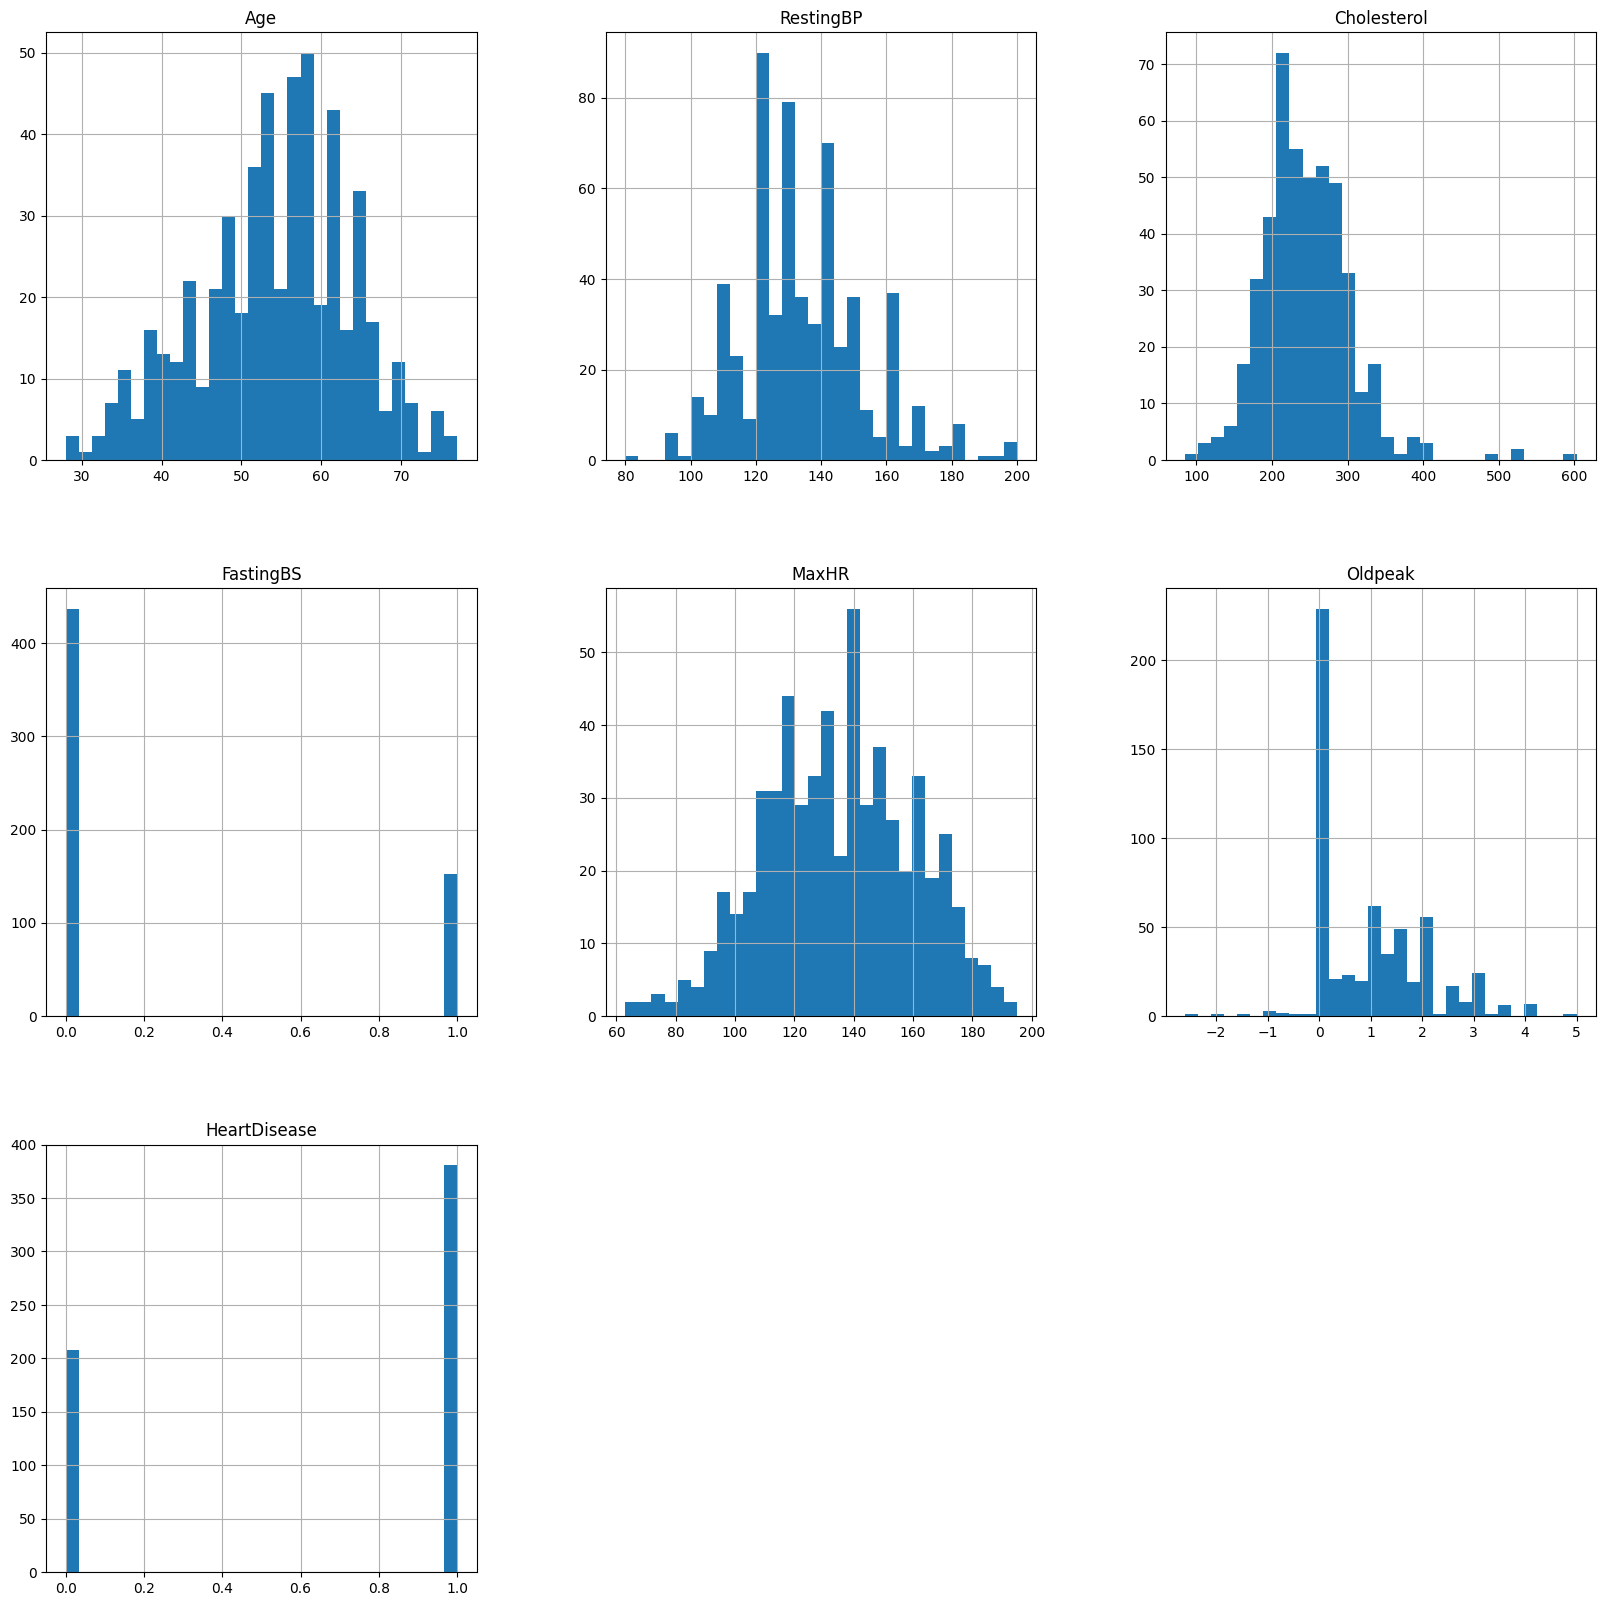

In [28]:
data_train.hist(figsize=(20,20), bins=30)

- По диаграммам можно оценить исходное распределение значений в фичах

- построим диаграммы размаха для числовых  значений для определения выбросных значений

In [29]:
fig = make_subplots(rows=(len(data_train[num_columns].columns)+1), cols=1, vertical_spacing=0.014)

for i, col in enumerate(data_train[num_columns].columns):
    fig.append_trace(go.Box(x=data_train[col], name=col, orientation='h'), row=i+1, col=1)
    
fig.append_trace(go.Box(x=pd.to_datetime(data_train['Age'], dayfirst=True).sort_values(ascending=True), name='Age', orientation='h'), row=(len(data_train[num_columns].columns)+1), col=1)

fig.update_layout(height=2000, width=1110, showlegend=False)
fig.show()

- в данных не очень много выбросных значений

- Построим столбчатые диаграммы для категориальных признаков

In [30]:
cat_columns = []
for column in data_train:
    if data_train[column].dtype == 'object':
        cat_columns.append(column)
for column in cat_columns:
    value_counts = data_train[column].value_counts()
    fig = px.bar(x=value_counts.index, y=value_counts.values)
    fig.update_layout(
        xaxis_title='Категории',
        yaxis_title='Значения',
        title = 'График для столбца ' + column
    )
    fig.show()

- оценим распределение по классам в фичах


 - Построение матриц корреляции для анализа зависимости в КАТЕГОРИАЛЬНЫХ данных с целевым признаком (`HeartDisease`) 

interval columns not set, guessing: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']


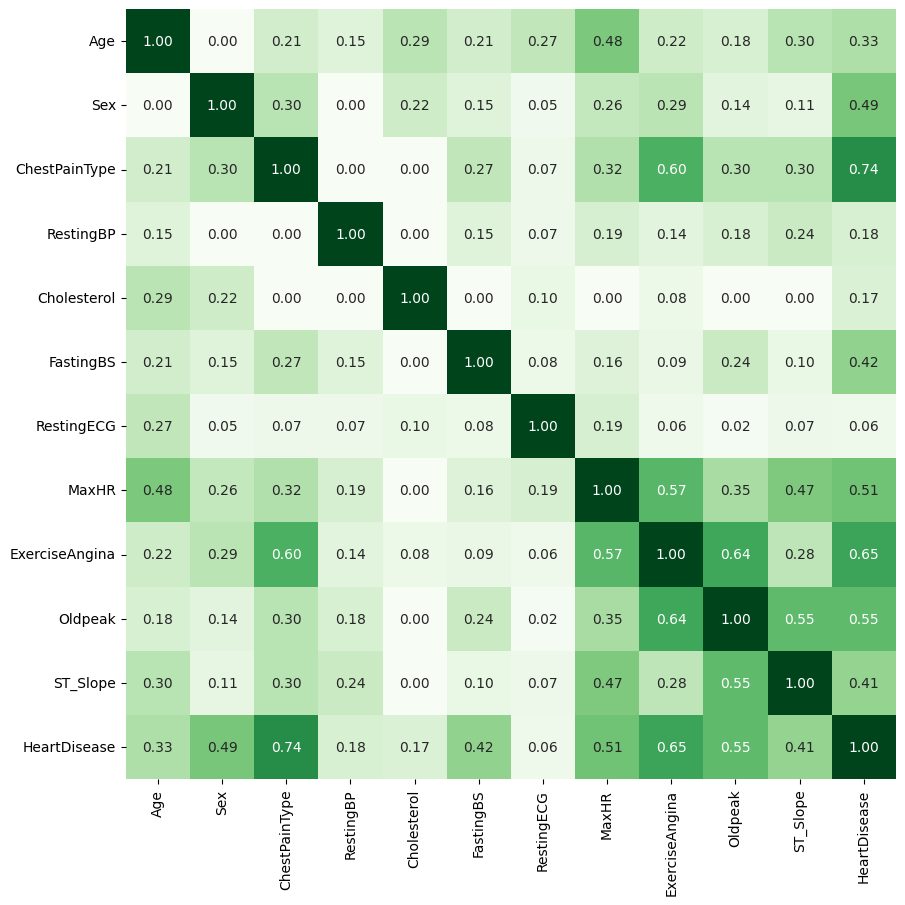

In [31]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(data_train.phik_matrix().round(2),
            cmap='Greens',
            square=True,
            vmin=0,
            annot=True,
            cbar=False,
            annot_kws={'fontsize': 10},
            fmt='.2f',
            ax=ax)

plt.xticks(rotation=90)

plt.show()

`Выводы:`
- высокую зависимость с целевой переменной имеют данные из колонок ChestPainType, ExerciseAngina, Oldpeak, MaxHR

- колонки с низкой зависимостью можно удалить: RestingECG, Cholesterol, RestingBP
---------------------

- разделим данные на обучающую и тестовую части

In [32]:
target_train = data_train['HeartDisease']
features_train = data_train.drop('HeartDisease', axis=1)

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'RestingBP'}>],
       [<Axes: title={'center': 'Cholesterol'}>,
        <Axes: title={'center': 'FastingBS'}>],
       [<Axes: title={'center': 'MaxHR'}>,
        <Axes: title={'center': 'Oldpeak'}>]], dtype=object)

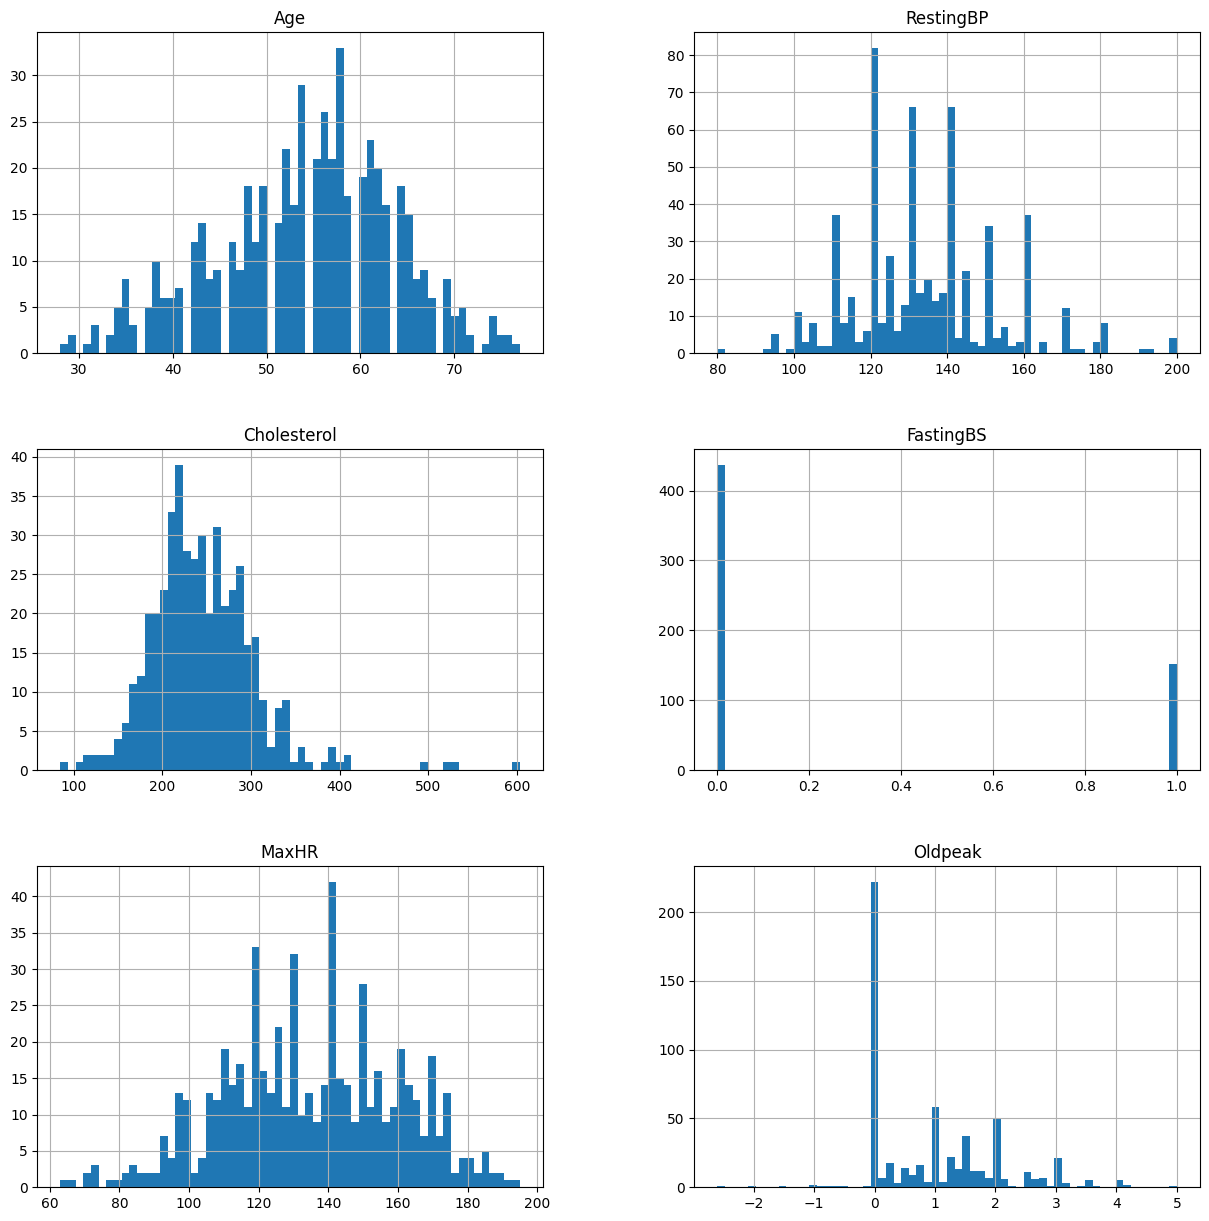

In [33]:
features_train.hist(figsize=(15,15), bins=60)

- Так как классы не очень сбалансированны, при обучении моделей требуется учитывать веса в лоссе 

- создадим трансформер для заполнения пропусков в колонке 'Age'

In [34]:
class MeanImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.imputer = SimpleImputer(strategy='mean')
    
    def fit(self, X, y=None):
        self.imputer.fit(X[self.columns])
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.columns] = self.imputer.transform(X_copy[self.columns])
        return X_copy

In [35]:
data_train['Age'].isnull().sum()

56

<Axes: >

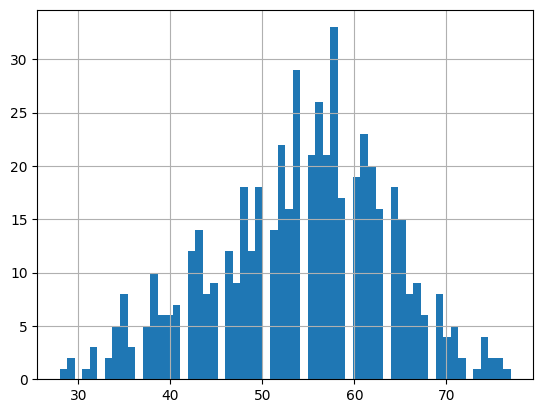

In [36]:
data_train['Age'].hist(bins=60)

Применим трансформер на базе библиотечной модели SimpleImputer к нашим данным - колонке 'Age'

In [37]:
mean_imputer_si = MeanImputer(columns=['Age'])
mean_imputer_si.fit(features_train)

# применим трансформер
transformed_data = mean_imputer_si.transform(features_train)
features_train = transformed_data
features_train

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,74.000000,M,NAP,138.0,NaN,0,Normal,116,N,0.2,Up
1,58.000000,M,NAP,132.0,224.0,0,LVH,173,N,3.2,Up
2,44.000000,M,ATA,150.0,288.0,0,Normal,150,Y,3.0,Flat
3,50.000000,M,ASY,144.0,349.0,0,LVH,120,Y,1.0,Up
4,54.195122,M,ASY,145.0,248.0,0,Normal,96,Y,2.0,Flat
...,...,...,...,...,...,...,...,...,...,...,...
584,58.000000,M,ASY,115.0,NaN,1,Normal,138,N,0.5,Up
585,56.000000,M,ASY,132.0,184.0,0,LVH,105,Y,2.1,Flat
586,52.000000,M,ATA,134.0,201.0,0,Normal,158,N,0.8,Up
587,49.000000,M,NAP,131.0,142.0,0,Normal,127,Y,1.5,Flat


- для дальнейшей работы требуется перевести категориальные данные в числовой вид. Делаем  onehotencoding 

- преобразования с колонками

Sex - M, F

ChestPainType - TA, ATA, NAP, ASY

ExerciseAngina (Y и N) заменим - 1 и 0

ST_Slope - Flat, UP, Down

так как фичи 'RestingECG', 'Cholesterol', 'RestingBP' имеют слабую корреляцию с целевым признаком избавляемся от них

In [38]:
types_new_col = ['M','F','TA', 'ATA','NAP', 'ASY','Y', 'N','Flat','UP','Down']

class DataToFlags(TransformerMixin, BaseEstimator):

    def __init__(self):
        self.types_new_col = types_new_col
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.reset_index(drop=True)
        
        ohe_types = pd.DataFrame.from_dict(
            list(
                X
                .apply(
                    lambda f: dict([
                        (
                            t, 1 if f['Sex'] == t or f['ChestPainType'] == t or f['ExerciseAngina'] == t or f['ST_Slope'] == t else 0
                        )
                        for t in self.types_new_col
                    ]),
                    axis=1
                )
            )
        )
        
        X = pd.concat([X.drop(['Sex'], axis=1), ohe_types], axis=1)
        X = X.drop(['F'], axis=1)
        X = pd.concat([X.drop(['ExerciseAngina'], axis=1)])
        X = X.drop(['N'], axis=1)
        X = pd.concat([X.drop(['ChestPainType'], axis=1)])
        X = X.drop(['TA'], axis=1)
        X = pd.concat([X.drop(['ST_Slope'], axis=1)])
        X = X.drop(['Down'], axis=1)
        X = X.drop(['RestingECG', 'Cholesterol', 'RestingBP'], axis=1)
        return X

In [39]:
dtf = DataToFlags()
dtf.fit(features_train)
features_train_new = dtf.transform(features_train)

features_train_new

,Age,FastingBS,MaxHR,Oldpeak,M,ATA,NAP,ASY,Y,Flat,UP
0,74.000000,0,116,0.2,1,0,1,0,0,0,0
1,58.000000,0,173,3.2,1,0,1,0,0,0,0
2,44.000000,0,150,3.0,1,1,0,0,1,1,0
3,50.000000,0,120,1.0,1,0,0,1,1,0,0
4,54.195122,0,96,2.0,1,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
584,58.000000,1,138,0.5,1,0,0,1,0,0,0
585,56.000000,0,105,2.1,1,0,0,1,1,1,0
586,52.000000,0,158,0.8,1,1,0,0,0,0,0
587,49.000000,0,127,1.5,1,0,1,0,1,1,0


- Производим масштабирование признаков

In [40]:
scaler = StandardScaler()
scaler.fit(features_train_new)
columns = features_train_new.columns
features_train_sc = pd.DataFrame(scaler.transform(features_train_new), columns=columns)
features_train_sc.head(5)

,Age,FastingBS,MaxHR,Oldpeak,M,ATA,NAP,ASY,Y,Flat,UP
0,2.186049,-0.589768,-0.758105,-0.689009,0.484563,-0.441278,2.008529,-1.201659,-0.901281,-1.109532,0.0
1,0.419980,-0.589768,1.529085,2.113660,0.484563,-0.441278,2.008529,-1.201659,-0.901281,-1.109532,0.0
2,-1.125331,-0.589768,0.606184,1.926815,0.484563,2.266146,-0.497877,-1.201659,1.109532,0.901281,0.0
3,-0.463055,-0.589768,-0.597600,0.058369,0.484563,-0.441278,-0.497877,0.832183,1.109532,-1.109532,0.0
4,0.000000,-0.589768,-1.560627,0.992592,0.484563,-0.441278,-0.497877,0.832183,1.109532,0.901281,0.0


- произведена подготовка к обучению датасета. Данные нормализованны

In [41]:
model_dtc = DecisionTreeClassifier(random_state=4, class_weight='balanced')
model_dtc.fit(features_train_sc, target_train)
print('Качество модели DecisionTreeClassifier на обучающей выборке:', {roc_auc_score(target_train, model_dtc.predict_proba(features_train_sc)[:, 1])})

Качество модели DecisionTreeClassifier на обучающей выборке: {0.9999936906925097}


In [42]:
model_lr = LogisticRegression(random_state=4, class_weight='balanced')
model_lr.fit(features_train_sc, target_train)
print('Качество модели LogisticRegression на обучающей выборке:', {roc_auc_score(target_train, model_lr.predict_proba(features_train_sc)[:, 1])})

Качество модели LogisticRegression на обучающей выборке: {0.9370141833232384}


- модель явно DecisionTreeClassifier переобучилась, но вот LogisticRegression показывает нормальный скор

----------

- подгрузим тестовую выборку

In [43]:
data_test = pd.read_csv('heart_adapt_test.csv')
data_test.sample(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
192,38.0,M,ATA,140.0,297.0,0,Normal,150,N,0.0,Up,0
175,48.0,M,ASY,130.0,256.0,1,LVH,150,Y,0.0,Up,1
46,53.0,F,ATA,113.0,468.0,0,Normal,127,N,0.0,Up,0
98,63.0,M,ASY,96.0,305.0,0,ST,121,Y,1.0,Up,1
147,64.0,M,ASY,128.0,263.0,0,Normal,105,Y,0.2,Flat,0


- разделим тестовый датасет на выборки


In [44]:
target = data_test['HeartDisease']
features = data_test.drop('HeartDisease', axis=1)

-------------

- Создаем наш `Pipeline`

Производим объединение методов

1.  трансформер на базе библиотечной модели SimpleImputer заполняющий пропуски в столбце Age - MultivariateImputer_SI

2.  трансформер приводящий к числовому виду категориальные переменные в датафрейме - DataToFlags

3. трансформер производящий масштабирование данных features_train_sc



In [50]:
pipe = Pipeline([  
    ('mean_imputer', MeanImputer(columns=['Age'])),
    ('ohe_types', DataToFlags()),
    ('scaler', StandardScaler()),
    ('classify', DecisionTreeClassifier(class_weight='balanced', random_state=0))
])

pipe.fit(X=features_train, y=target_train)

Pipeline(steps=[('mean_imputer', MeanImputer(columns=['Age'])),
                ('ohe_types', DataToFlags()), ('scaler', StandardScaler()),
                ('classify',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=0))])

In [51]:
print('Качество модели на тестовой выборке:', {roc_auc_score(target, pipe.predict_proba(features)[:, 1])})

Качество модели на тестовой выборке: {0.7818897637795276}


In [52]:
pipe['classify'].tree_.max_depth

12

In [57]:
params = [
    {'classify': [DecisionTreeClassifier(class_weight='balanced', random_state=0)], 'classify__max_depth': [2, 4, 6, 12, 22, 26]}, 
    {'classify': [LogisticRegression(class_weight='balanced', random_state=0)]}
]

grid_search = GridSearchCV(pipe, param_grid=params, cv=5, scoring='roc_auc')
grid_search.fit(X=features_train, y=target_train)
print(
    'Качество модели на тестовой выборке c лучшей моделью:', 
    {roc_auc_score(target, grid_search.predict_proba(features)[:, 1])}
)


Качество модели на тестовой выборке c лучшей моделью: {0.9075365579302587}


In [54]:
grid_search.best_estimator_

Pipeline(steps=[('mean_imputer', MeanImputer(columns=['Age'])),
                ('ohe_types', DataToFlags()), ('scaler', StandardScaler()),
                ('classify',
                 LogisticRegression(class_weight='balanced', random_state=0))])

---------
# ВЫВОДЫ:

Лучше всего показала себя модель `LogisticRegression`

После дополнительной обработки GridSearchCV с поиском наилучшей модели и подбором гиперпараметров

удалось достичь точности в `0.9075` по `roc_auc_score`

- DecisionTreeClassifier показывает точность по roc_auc_score 0.8377
